# Imports

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_curve, auc
)

import shap
from xgboost import XGBClassifier

pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

In [38]:
df = pd.read_csv('data_clean_name.csv')

In [39]:
scaling_factors = {
    "Procalcitonin": 1000,          
    "White Blood Cell Count": 10,   
    "Creatinine": 88.4,             
    "Urea": 2.14,                   
    "Bilirubin": 17.1,              
    "Albumin": 10                   
}

for col, factor in scaling_factors.items():
    df[col] = df[col] / factor


In [40]:
different_distribution_features = [
    "SOFA",  
    "APACHEII",  
    "Mean Arterial Pressure",  
    "Lactate",  
    "Creatinine",  
    "Procalcitonin",  
    "Bilirubin",  
    "White Blood Cell Count",  
]

In [41]:
columns_to_impute = ["Respiratory Rate", "Albumin", 'Bilirubin', 'Procalcitonin', 'HCO3']

df[columns_to_impute] = df.groupby(["Gender", "Hypertension", "Outcome of acute kidney injury"])[columns_to_impute].transform(lambda x: x.fillna(x.median()))

In [42]:
df_transformed = df.copy()

log_transform_cols = ['Procalcitonin', 'Creatinine', 'Urea', 'Lactate', 'HCO3', 'Mean Arterial Pressure']
sqrt_transform_cols = ['White Blood Cell Count', 'APACHEII', 'SOFA']

for col in log_transform_cols + sqrt_transform_cols:
    if col in log_transform_cols:
        df_transformed[col] = np.log1p(df[col])
        df[col] = np.log1p(df[col])
        
    if col in sqrt_transform_cols:
        df_transformed[col] = np.sqrt(df[col].clip(lower=0))
        df[col] = np.sqrt(df[col].clip(lower=0))

In [43]:
def remove_outliers(df):
    cols = ['Mechanical Ventilation', 'Procalcitonin', 'Creatinine',
            'Bilirubin', 'White Blood Cell Count']

    df_clean = df.copy()

    for col in cols:
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1

        lower = q1 - 2.5 * iqr
        upper = q3 + 2.5 * iqr
        
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    
    return df_clean


In [44]:
df1 = df.iloc[:98, :].copy()
df2 = df.iloc[99:210, :].copy()
df3 = df.iloc[211:411, :].copy()
df4 = df.iloc[412:531, :].copy()

In [45]:
df1 = remove_outliers(df1)
df2 = remove_outliers(df2)
df3 = remove_outliers(df3)
df4 = remove_outliers(df4)

df = pd.concat([df1,df2,df3,df4])

In [46]:
X = df[
    [
            'HCO3','Creatinine', 'Procalcitonin', 'Mean Arterial Pressure',
            'Bilirubin','pH','Albumin', 'Urea', 'White Blood Cell Count', 
            'SOFA', 'APACHEII', 'Glasgow'
    ]
]

y = df['Dialysis treatment']

In [47]:
categorical_cols = X.select_dtypes(include=['object']).columns

X[categorical_cols] = X[categorical_cols].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [48]:
param_grid = {'colsample_bytree': 1.0,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.8}

In [49]:
best_model = XGBClassifier(enable_categorical=True, random_state=42)
best_model.set_params(**param_grid)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [50]:
y_pred = best_model.predict(X_test)

y_scores = best_model.predict_proba(X_test)[:, 1]

threshold_recall = 0.36  
y_pred_adjusted = (y_scores >= threshold_recall).astype(int)

Classification Report (Recall Priority):
               precision    recall  f1-score   support

           0       0.94      0.87      0.91        55
           1       0.77      0.89      0.83        27

    accuracy                           0.88        82
   macro avg       0.86      0.88      0.87        82
weighted avg       0.89      0.88      0.88        82



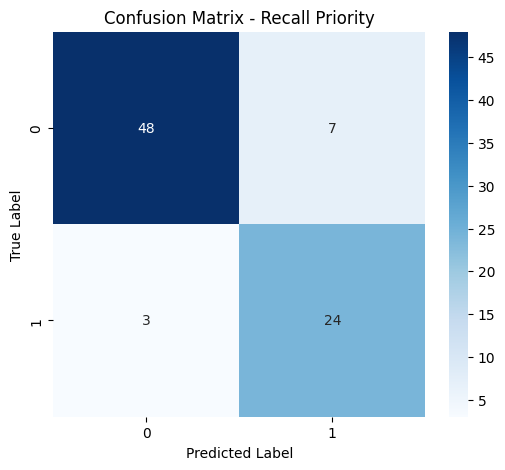

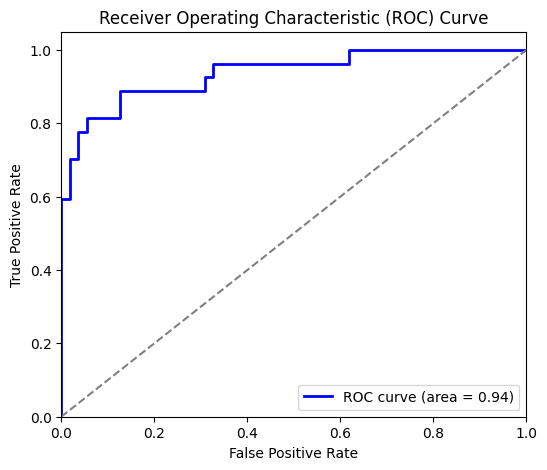

In [51]:
accuracy = accuracy_score(y_pred_adjusted, y_test)

# Compute confusion matrix and classification report for recall-prioritized model
cm_recall = confusion_matrix(y_test, y_pred_adjusted)
print("Classification Report (Recall Priority):\n", classification_report(y_test, y_pred_adjusted))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_recall, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Recall Priority")
plt.show()

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [52]:
accuracy

0.8780487804878049

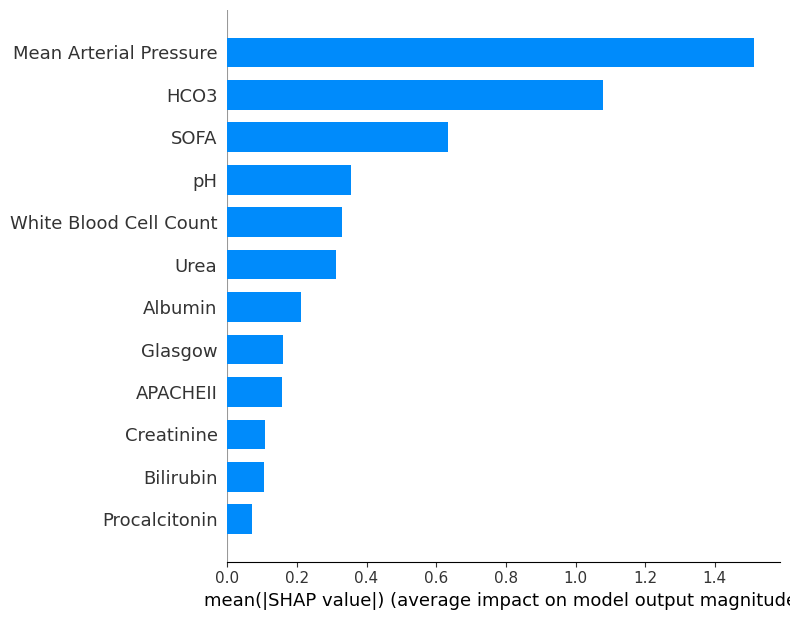

In [53]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

In [54]:

os.makedirs("model_artifact", exist_ok=True)

model_path = "model_artifact/model.xgb"
best_model.get_booster().save_model(model_path)

print(f"Saved XGBoost model to {model_path}")


Saved XGBoost model to model_artifact/model.xgb
